<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/modelado-tres-modos/2_Red_neuronal_recurrente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#import keras_tuner

In [ ]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Residuo.csv")
modo_1["FECHA"] = pd.to_datetime(modo_1["FECHA"],format='%Y-%m-%d')
modo_2["FECHA"] = pd.to_datetime(modo_2["FECHA"],format='%Y-%m-%d')
#modo_3["FECHA"] = pd.to_datetime(modo_3["FECHA"],format='%Y-%m-%d')
#modo_4["FECHA"] = pd.to_datetime(modo_4["FECHA"],format='%Y-%m-%d')
#modo_5["FECHA"] = pd.to_datetime(modo_5["FECHA"],format='%Y-%m-%d')
residuo["FECHA"] = pd.to_datetime(residuo["FECHA"],format='%Y-%m-%d')
modo_1.set_index("FECHA", inplace=True)
modo_2.set_index("FECHA", inplace=True)
#modo_3.set_index("FECHA", inplace=True)
#modo_4.set_index("FECHA", inplace=True)
#modo_5.set_index("FECHA", inplace=True)
residuo.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

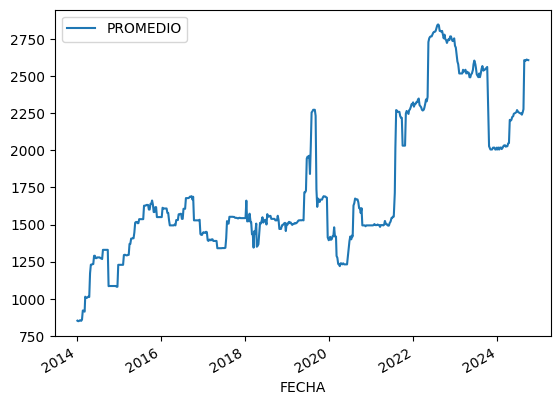

In [ ]:
datos_emd = modo_1 + modo_2 + residuo
datos_emd.plot()

In [ ]:
datos_emd.describe()

,PROMEDIO
count,554.000000
mean,1746.012635
std,484.698883
min,848.000000
25%,1448.000000
50%,1543.000000
75%,2162.500000
max,2850.000000


In [ ]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
import optuna
from keras.optimizers import Adam

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(LSTM(trial.suggest_int('units', 7, 70), input_shape=(1,7),return_sequences=True)) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,10)): # Número de capas ocultas
        model.add(LSTM(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh',return_sequences=True)) # Capas ocultas con unidades variables
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=tf.keras.optimizers.RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

In [ ]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

#Modelamos modo 1

In [ ]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434


In [ ]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values
datos_validacion_m1_values = datos_validacion_m1.values
datos_testeo_m1_values = datos_testeo_m1.values

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


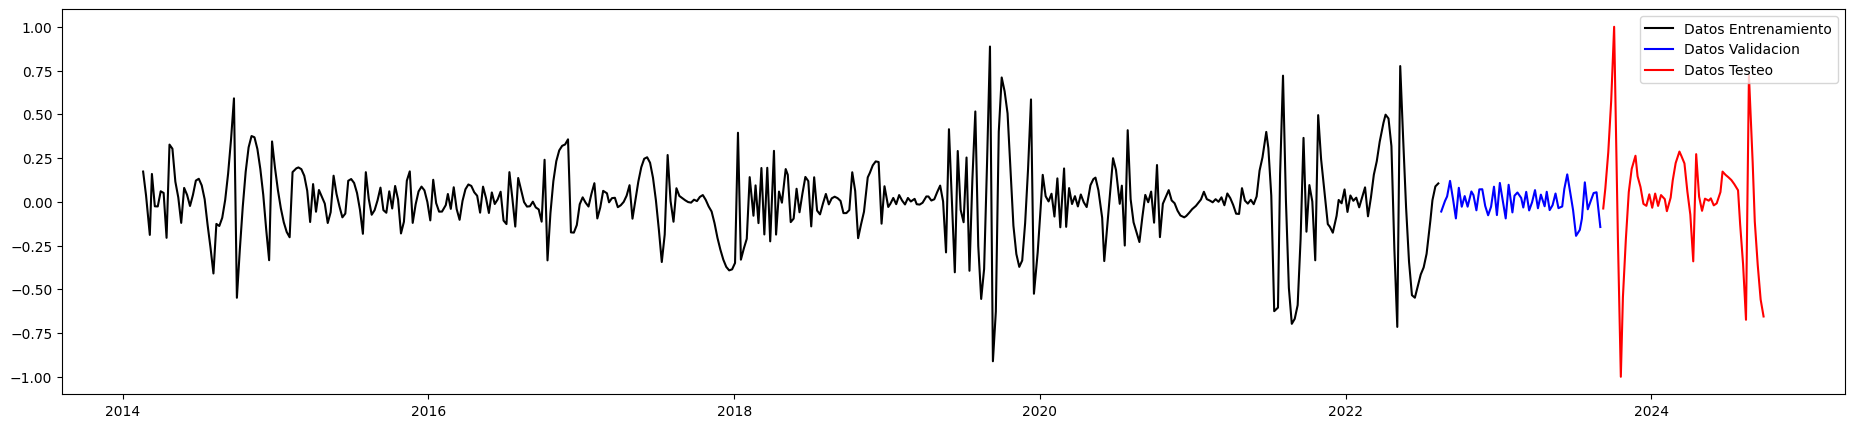

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-10-05 17:10:11,150] A new study created in memory with name: no-name-404ffcfd-fcdd-45f8-92de-41cfdeba4b1c


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 997ms/step


[I 2024-10-05 17:10:26,181] Trial 0 finished with value: 1.1827051639556885 and parameters: {'units': 47, 'n_layers': 6, 'units_0': 48, 'units_1': 51, 'units_2': 12, 'units_3': 62, 'units_4': 27, 'units_5': 8, 'learning_rate': 0.016941699849478638}. Best is trial 0 with value: 1.1827051639556885.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:10:43,903] Trial 1 finished with value: 1.3272501230239868 and parameters: {'units': 25, 'n_layers': 8, 'units_0': 29, 'units_1': 16, 'units_2': 28, 'units_3': 13, 'units_4': 59, 'units_5': 17, 'units_6': 60, 'units_7': 64, 'learning_rate': 0.08402797805848093}. Best is trial 0 with value: 1.1827051639556885.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:10:59,836] Trial 2 finished with value: 1.1833947896957397 and parameters: {'units': 19, 'n_layers': 7, 'units_0': 45, 'units_1': 33, 'units_2': 58, 'units_3': 50, 'units_4': 57, 'units_5': 70, 'units_6': 45, 'learning_rate': 0.04123683081400827}. Best is trial 0 with value: 1.1827051639556885.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:11:19,588] Trial 3 finished with value: 1.292804479598999 and parameters: {'units': 59, 'n_layers': 9, 'units_0': 11, 'units_1': 54, 'units_2': 47, 'units_3': 8, 'units_4': 36, 'units_5': 70, 'units_6': 58, 'units_7': 67, 'units_8': 37, 'learning_rate': 0.03758598782108889}. Best is trial 0 with value: 1.1827051639556885.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:11:36,417] Trial 4 finished with value: 0.7531605958938599 and parameters: {'units': 47, 'n_layers': 6, 'units_0': 42, 'units_1': 32, 'units_2': 24, 'units_3': 41, 'units_4': 68, 'units_5': 48, 'learning_rate': 0.05973571915952662}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


[I 2024-10-05 17:11:43,571] Trial 5 finished with value: 1.0009790658950806 and parameters: {'units': 20, 'n_layers': 3, 'units_0': 34, 'units_1': 54, 'units_2': 46, 'learning_rate': 0.044582835429129296}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:12:03,112] Trial 6 finished with value: 0.9456986784934998 and parameters: {'units': 11, 'n_layers': 8, 'units_0': 51, 'units_1': 49, 'units_2': 24, 'units_3': 36, 'units_4': 7, 'units_5': 36, 'units_6': 19, 'units_7': 33, 'learning_rate': 0.09739138475967914}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 843ms/step


[I 2024-10-05 17:12:14,509] Trial 7 finished with value: 1.3323982954025269 and parameters: {'units': 45, 'n_layers': 5, 'units_0': 29, 'units_1': 32, 'units_2': 42, 'units_3': 45, 'units_4': 37, 'learning_rate': 0.040942689364104175}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-10-05 17:12:20,232] Trial 8 finished with value: 1.0614739656448364 and parameters: {'units': 66, 'n_layers': 1, 'units_0': 21, 'learning_rate': 0.020925112466576197}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


[I 2024-10-05 17:12:30,463] Trial 9 finished with value: 1.2247689962387085 and parameters: {'units': 49, 'n_layers': 4, 'units_0': 64, 'units_1': 15, 'units_2': 46, 'units_3': 7, 'learning_rate': 0.09774235066359716}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:12:55,084] Trial 10 finished with value: 0.9823386669158936 and parameters: {'units': 32, 'n_layers': 10, 'units_0': 67, 'units_1': 26, 'units_2': 11, 'units_3': 31, 'units_4': 69, 'units_5': 47, 'units_6': 11, 'units_7': 8, 'units_8': 66, 'units_9': 34, 'learning_rate': 0.06848753248991615}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:13:10,499] Trial 11 finished with value: 1.3163813352584839 and parameters: {'units': 8, 'n_layers': 7, 'units_0': 56, 'units_1': 68, 'units_2': 26, 'units_3': 31, 'units_4': 10, 'units_5': 40, 'units_6': 15, 'learning_rate': 0.07021411041308978}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:13:31,160] Trial 12 finished with value: 1.091874122619629 and parameters: {'units': 37, 'n_layers': 8, 'units_0': 45, 'units_1': 42, 'units_2': 25, 'units_3': 33, 'units_4': 7, 'units_5': 50, 'units_6': 27, 'units_7': 28, 'learning_rate': 0.09993555050030596}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:13:47,886] Trial 13 finished with value: 1.360062599182129 and parameters: {'units': 56, 'n_layers': 6, 'units_0': 55, 'units_1': 45, 'units_2': 22, 'units_3': 22, 'units_4': 20, 'units_5': 31, 'learning_rate': 0.06379311180842702}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:14:09,537] Trial 14 finished with value: 1.1530593633651733 and parameters: {'units': 8, 'n_layers': 10, 'units_0': 40, 'units_1': 65, 'units_2': 18, 'units_3': 54, 'units_4': 47, 'units_5': 32, 'units_6': 33, 'units_7': 39, 'units_8': 14, 'units_9': 69, 'learning_rate': 0.08310410985786762}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


[I 2024-10-05 17:14:18,284] Trial 15 finished with value: 1.449305772781372 and parameters: {'units': 33, 'n_layers': 3, 'units_0': 58, 'units_1': 7, 'units_2': 31, 'learning_rate': 0.05664781785258854}. Best is trial 4 with value: 0.7531605958938599.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:14:37,937] Trial 16 finished with value: 0.7467754483222961 and parameters: {'units': 69, 'n_layers': 8, 'units_0': 51, 'units_1': 28, 'units_2': 35, 'units_3': 43, 'units_4': 49, 'units_5': 54, 'units_6': 23, 'units_7': 39, 'learning_rate': 0.08129503833651476}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 832ms/step


[I 2024-10-05 17:14:50,941] Trial 17 finished with value: 1.6505248546600342 and parameters: {'units': 70, 'n_layers': 5, 'units_0': 38, 'units_1': 25, 'units_2': 34, 'units_3': 70, 'units_4': 70, 'learning_rate': 0.081404434351881}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:15:06,975] Trial 18 finished with value: 1.3959327936172485 and parameters: {'units': 60, 'n_layers': 7, 'units_0': 21, 'units_1': 37, 'units_2': 69, 'units_3': 42, 'units_4': 50, 'units_5': 58, 'units_6': 44, 'learning_rate': 0.05597274803986649}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step


[I 2024-10-05 17:15:12,470] Trial 19 finished with value: 1.038667917251587 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.004291483659032147}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:15:35,000] Trial 20 finished with value: 1.3136099576950073 and parameters: {'units': 41, 'n_layers': 9, 'units_0': 39, 'units_1': 23, 'units_2': 36, 'units_3': 55, 'units_4': 60, 'units_5': 57, 'units_6': 7, 'units_7': 44, 'units_8': 67, 'learning_rate': 0.0781598442612811}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:15:52,257] Trial 21 finished with value: 0.7689418792724609 and parameters: {'units': 27, 'n_layers': 8, 'units_0': 51, 'units_1': 46, 'units_2': 18, 'units_3': 38, 'units_4': 46, 'units_5': 40, 'units_6': 22, 'units_7': 25, 'learning_rate': 0.08904549240452275}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:16:13,970] Trial 22 finished with value: 1.2407159805297852 and parameters: {'units': 28, 'n_layers': 9, 'units_0': 52, 'units_1': 35, 'units_2': 18, 'units_3': 43, 'units_4': 46, 'units_5': 47, 'units_6': 25, 'units_7': 15, 'units_8': 11, 'learning_rate': 0.08809848336698725}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:16:30,312] Trial 23 finished with value: 1.326938509941101 and parameters: {'units': 40, 'n_layers': 7, 'units_0': 44, 'units_1': 42, 'units_2': 7, 'units_3': 24, 'units_4': 52, 'units_5': 57, 'units_6': 34, 'learning_rate': 0.07463380765685092}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:16:45,167] Trial 24 finished with value: 1.3881983757019043 and parameters: {'units': 63, 'n_layers': 6, 'units_0': 69, 'units_1': 30, 'units_2': 19, 'units_3': 49, 'units_4': 41, 'units_5': 41, 'learning_rate': 0.05919125075725212}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:17:09,131] Trial 25 finished with value: 1.8091039657592773 and parameters: {'units': 16, 'n_layers': 8, 'units_0': 51, 'units_1': 20, 'units_2': 39, 'units_3': 38, 'units_4': 30, 'units_5': 52, 'units_6': 22, 'units_7': 52, 'learning_rate': 0.08965578272712822}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


[I 2024-10-05 17:17:19,630] Trial 26 finished with value: 1.410466194152832 and parameters: {'units': 26, 'n_layers': 4, 'units_0': 33, 'units_1': 61, 'units_2': 31, 'units_3': 25, 'learning_rate': 0.0916926246075592}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:17:42,706] Trial 27 finished with value: 1.2309212684631348 and parameters: {'units': 33, 'n_layers': 9, 'units_0': 60, 'units_1': 29, 'units_2': 14, 'units_3': 40, 'units_4': 65, 'units_5': 28, 'units_6': 42, 'units_7': 24, 'units_8': 41, 'learning_rate': 0.07372094632070386}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:17:58,313] Trial 28 finished with value: 1.178427815437317 and parameters: {'units': 53, 'n_layers': 7, 'units_0': 42, 'units_1': 38, 'units_2': 58, 'units_3': 59, 'units_4': 54, 'units_5': 63, 'units_6': 32, 'learning_rate': 0.03226187272029621}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step


[I 2024-10-05 17:18:11,027] Trial 29 finished with value: 1.4168081283569336 and parameters: {'units': 45, 'n_layers': 5, 'units_0': 49, 'units_1': 45, 'units_2': 7, 'units_3': 48, 'units_4': 44, 'learning_rate': 0.04907295155282373}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 949ms/step


[I 2024-10-05 17:18:25,823] Trial 30 finished with value: 1.3232568502426147 and parameters: {'units': 70, 'n_layers': 6, 'units_0': 48, 'units_1': 11, 'units_2': 30, 'units_3': 27, 'units_4': 61, 'units_5': 41, 'learning_rate': 0.06309203662127386}. Best is trial 16 with value: 0.7467754483222961.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:18:49,487] Trial 31 finished with value: 0.7128512263298035 and parameters: {'units': 13, 'n_layers': 8, 'units_0': 54, 'units_1': 49, 'units_2': 24, 'units_3': 36, 'units_4': 19, 'units_5': 36, 'units_6': 16, 'units_7': 30, 'learning_rate': 0.09403105223884481}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:19:06,894] Trial 32 finished with value: 1.0664236545562744 and parameters: {'units': 14, 'n_layers': 8, 'units_0': 54, 'units_1': 53, 'units_2': 14, 'units_3': 35, 'units_4': 17, 'units_5': 26, 'units_6': 16, 'units_7': 21, 'learning_rate': 0.09191703001654679}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:19:24,290] Trial 33 finished with value: 1.4235913753509521 and parameters: {'units': 24, 'n_layers': 8, 'units_0': 47, 'units_1': 48, 'units_2': 21, 'units_3': 40, 'units_4': 33, 'units_5': 44, 'units_6': 26, 'units_7': 38, 'learning_rate': 0.08417325054791808}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:19:46,275] Trial 34 finished with value: 1.3615460395812988 and parameters: {'units': 18, 'n_layers': 10, 'units_0': 63, 'units_1': 59, 'units_2': 27, 'units_3': 47, 'units_4': 21, 'units_5': 37, 'units_6': 12, 'units_7': 49, 'units_8': 43, 'units_9': 12, 'learning_rate': 0.08029811528784922}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:20:02,773] Trial 35 finished with value: 1.3939523696899414 and parameters: {'units': 24, 'n_layers': 7, 'units_0': 57, 'units_1': 39, 'units_2': 35, 'units_3': 29, 'units_4': 41, 'units_5': 51, 'units_6': 52, 'learning_rate': 0.08682683160615667}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


[I 2024-10-05 17:20:29,138] Trial 36 finished with value: 0.9362543821334839 and parameters: {'units': 29, 'n_layers': 9, 'units_0': 35, 'units_1': 59, 'units_2': 16, 'units_3': 18, 'units_4': 65, 'units_5': 22, 'units_6': 21, 'units_7': 31, 'units_8': 28, 'learning_rate': 0.09241572072296382}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:20:43,885] Trial 37 finished with value: 1.4105721712112427 and parameters: {'units': 38, 'n_layers': 6, 'units_0': 43, 'units_1': 21, 'units_2': 22, 'units_3': 53, 'units_4': 31, 'units_5': 34, 'learning_rate': 0.07738204423281521}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:21:01,782] Trial 38 finished with value: 1.3853803873062134 and parameters: {'units': 20, 'n_layers': 8, 'units_0': 10, 'units_1': 42, 'units_2': 42, 'units_3': 37, 'units_4': 26, 'units_5': 45, 'units_6': 68, 'units_7': 17, 'learning_rate': 0.03386557619070506}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:21:20,442] Trial 39 finished with value: 0.8292929530143738 and parameters: {'units': 11, 'n_layers': 9, 'units_0': 29, 'units_1': 50, 'units_2': 11, 'units_3': 43, 'units_4': 55, 'units_5': 62, 'units_6': 8, 'units_7': 36, 'units_8': 58, 'learning_rate': 0.09431212844051513}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:21:36,048] Trial 40 finished with value: 1.0165696144104004 and parameters: {'units': 49, 'n_layers': 7, 'units_0': 53, 'units_1': 33, 'units_2': 52, 'units_3': 36, 'units_4': 49, 'units_5': 52, 'units_6': 30, 'learning_rate': 0.07004826100466753}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:21:59,310] Trial 41 finished with value: 2.018359899520874 and parameters: {'units': 12, 'n_layers': 9, 'units_0': 22, 'units_1': 50, 'units_2': 11, 'units_3': 44, 'units_4': 54, 'units_5': 63, 'units_6': 10, 'units_7': 36, 'units_8': 56, 'learning_rate': 0.09529920231967237}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:22:22,024] Trial 42 finished with value: 1.1923651695251465 and parameters: {'units': 11, 'n_layers': 10, 'units_0': 28, 'units_1': 56, 'units_2': 11, 'units_3': 41, 'units_4': 57, 'units_5': 10, 'units_6': 16, 'units_7': 27, 'units_8': 55, 'units_9': 70, 'learning_rate': 0.09551332070868779}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


[I 2024-10-05 17:22:45,415] Trial 43 finished with value: 1.5513830184936523 and parameters: {'units': 21, 'n_layers': 8, 'units_0': 16, 'units_1': 45, 'units_2': 29, 'units_3': 51, 'units_4': 41, 'units_5': 65, 'units_6': 7, 'units_7': 43, 'learning_rate': 0.08663383335545267}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:23:06,768] Trial 44 finished with value: 1.1653985977172852 and parameters: {'units': 15, 'n_layers': 9, 'units_0': 30, 'units_1': 48, 'units_2': 24, 'units_3': 45, 'units_4': 64, 'units_5': 58, 'units_6': 19, 'units_7': 33, 'units_8': 53, 'learning_rate': 0.09668941233284892}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:23:24,009] Trial 45 finished with value: 1.143317461013794 and parameters: {'units': 9, 'n_layers': 8, 'units_0': 25, 'units_1': 29, 'units_2': 14, 'units_3': 33, 'units_4': 56, 'units_5': 54, 'units_6': 38, 'units_7': 54, 'learning_rate': 0.025450025105072535}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:23:42,918] Trial 46 finished with value: 1.4473021030426025 and parameters: {'units': 43, 'n_layers': 9, 'units_0': 37, 'units_1': 52, 'units_2': 20, 'units_3': 34, 'units_4': 44, 'units_5': 66, 'units_6': 14, 'units_7': 21, 'units_8': 25, 'learning_rate': 0.09970962157637037}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:24:07,215] Trial 47 finished with value: 1.372411847114563 and parameters: {'units': 66, 'n_layers': 10, 'units_0': 46, 'units_1': 56, 'units_2': 26, 'units_3': 39, 'units_4': 51, 'units_5': 45, 'units_6': 22, 'units_7': 43, 'units_8': 48, 'units_9': 11, 'learning_rate': 0.04746308370545906}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:24:24,293] Trial 48 finished with value: 1.3263734579086304 and parameters: {'units': 7, 'n_layers': 8, 'units_0': 49, 'units_1': 17, 'units_2': 17, 'units_3': 30, 'units_4': 36, 'units_5': 38, 'units_6': 10, 'units_7': 27, 'learning_rate': 0.06621811877983512}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


[I 2024-10-05 17:24:35,528] Trial 49 finished with value: 1.6485801935195923 and parameters: {'units': 36, 'n_layers': 4, 'units_0': 42, 'units_1': 26, 'units_2': 10, 'units_3': 47, 'learning_rate': 0.07463107669415908}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


[I 2024-10-05 17:24:41,484] Trial 50 finished with value: 1.5026650428771973 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 15, 'units_1': 35, 'learning_rate': 0.08266956857906343}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:25:01,248] Trial 51 finished with value: 1.228058099746704 and parameters: {'units': 29, 'n_layers': 9, 'units_0': 35, 'units_1': 62, 'units_2': 16, 'units_3': 19, 'units_4': 66, 'units_5': 19, 'units_6': 19, 'units_7': 32, 'units_8': 25, 'learning_rate': 0.09320052965053072}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


[I 2024-10-05 17:25:22,716] Trial 52 finished with value: 1.2899816036224365 and parameters: {'units': 30, 'n_layers': 7, 'units_0': 32, 'units_1': 59, 'units_2': 22, 'units_3': 12, 'units_4': 63, 'units_5': 21, 'units_6': 22, 'learning_rate': 0.08970665488725521}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:25:47,640] Trial 53 finished with value: 1.2383451461791992 and parameters: {'units': 34, 'n_layers': 10, 'units_0': 36, 'units_1': 70, 'units_2': 14, 'units_3': 14, 'units_4': 68, 'units_5': 24, 'units_6': 28, 'units_7': 31, 'units_8': 30, 'units_9': 43, 'learning_rate': 0.08565250608719398}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:26:08,742] Trial 54 finished with value: 1.2017440795898438 and parameters: {'units': 21, 'n_layers': 9, 'units_0': 40, 'units_1': 47, 'units_2': 33, 'units_3': 20, 'units_4': 61, 'units_5': 13, 'units_6': 18, 'units_7': 38, 'units_8': 32, 'learning_rate': 0.09363131294181984}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:26:28,432] Trial 55 finished with value: 1.5687745809555054 and parameters: {'units': 55, 'n_layers': 9, 'units_0': 26, 'units_1': 66, 'units_2': 9, 'units_3': 65, 'units_4': 57, 'units_5': 15, 'units_6': 23, 'units_7': 30, 'units_8': 18, 'learning_rate': 0.09930944053356686}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:26:45,312] Trial 56 finished with value: 1.2065014839172363 and parameters: {'units': 49, 'n_layers': 8, 'units_0': 51, 'units_1': 41, 'units_2': 16, 'units_3': 44, 'units_4': 13, 'units_5': 47, 'units_6': 12, 'units_7': 60, 'learning_rate': 0.005468791465984009}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:27:06,041] Trial 57 finished with value: 1.0556820631027222 and parameters: {'units': 27, 'n_layers': 10, 'units_0': 59, 'units_1': 51, 'units_2': 38, 'units_3': 52, 'units_4': 70, 'units_5': 61, 'units_6': 37, 'units_7': 22, 'units_8': 61, 'units_9': 45, 'learning_rate': 0.0798794325988589}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 828ms/step


[I 2024-10-05 17:27:18,466] Trial 58 finished with value: 1.2618169784545898 and parameters: {'units': 60, 'n_layers': 5, 'units_0': 32, 'units_1': 57, 'units_2': 25, 'units_3': 58, 'units_4': 48, 'learning_rate': 0.09019430601724619}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:27:36,731] Trial 59 finished with value: 1.0410070419311523 and parameters: {'units': 13, 'n_layers': 7, 'units_0': 55, 'units_1': 54, 'units_2': 24, 'units_3': 16, 'units_4': 67, 'units_5': 70, 'units_6': 7, 'learning_rate': 0.04281195506983054}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:27:55,919] Trial 60 finished with value: 1.5721893310546875 and parameters: {'units': 17, 'n_layers': 9, 'units_0': 66, 'units_1': 31, 'units_2': 19, 'units_3': 33, 'units_4': 59, 'units_5': 55, 'units_6': 14, 'units_7': 36, 'units_8': 7, 'learning_rate': 0.07224224456182218}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:28:13,380] Trial 61 finished with value: 1.614424705505371 and parameters: {'units': 10, 'n_layers': 8, 'units_0': 50, 'units_1': 46, 'units_2': 28, 'units_3': 42, 'units_4': 9, 'units_5': 36, 'units_6': 24, 'units_7': 34, 'learning_rate': 0.0963173365271285}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:28:37,842] Trial 62 finished with value: 1.801720380783081 and parameters: {'units': 31, 'n_layers': 7, 'units_0': 46, 'units_1': 44, 'units_2': 32, 'units_3': 38, 'units_4': 15, 'units_5': 30, 'units_6': 19, 'learning_rate': 0.08831292465052565}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:28:55,647] Trial 63 finished with value: 1.4101401567459106 and parameters: {'units': 14, 'n_layers': 8, 'units_0': 56, 'units_1': 49, 'units_2': 23, 'units_3': 27, 'units_4': 23, 'units_5': 34, 'units_6': 17, 'units_7': 41, 'learning_rate': 0.0925346852477712}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:29:15,200] Trial 64 finished with value: 0.9673367142677307 and parameters: {'units': 23, 'n_layers': 9, 'units_0': 53, 'units_1': 35, 'units_2': 20, 'units_3': 10, 'units_4': 45, 'units_5': 49, 'units_6': 21, 'units_7': 26, 'units_8': 21, 'learning_rate': 0.08415747208653965}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:29:28,282] Trial 65 finished with value: 1.3009017705917358 and parameters: {'units': 35, 'n_layers': 6, 'units_0': 62, 'units_1': 39, 'units_2': 13, 'units_3': 45, 'units_4': 10, 'units_5': 42, 'learning_rate': 0.05256682839096914}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:29:46,545] Trial 66 finished with value: 1.2488160133361816 and parameters: {'units': 10, 'n_layers': 8, 'units_0': 44, 'units_1': 51, 'units_2': 69, 'units_3': 36, 'units_4': 54, 'units_5': 32, 'units_6': 29, 'units_7': 30, 'learning_rate': 0.07707927070002789}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:30:02,569] Trial 67 finished with value: 1.4329941272735596 and parameters: {'units': 7, 'n_layers': 7, 'units_0': 40, 'units_1': 25, 'units_2': 16, 'units_3': 42, 'units_4': 18, 'units_5': 39, 'units_6': 13, 'learning_rate': 0.09828556254029715}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:30:19,944] Trial 68 finished with value: 1.3427023887634277 and parameters: {'units': 22, 'n_layers': 8, 'units_0': 58, 'units_1': 63, 'units_2': 51, 'units_3': 31, 'units_4': 63, 'units_5': 42, 'units_6': 26, 'units_7': 34, 'learning_rate': 0.06100842887289657}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:30:40,900] Trial 69 finished with value: 1.2055147886276245 and parameters: {'units': 41, 'n_layers': 9, 'units_0': 48, 'units_1': 28, 'units_2': 8, 'units_3': 50, 'units_4': 7, 'units_5': 48, 'units_6': 9, 'units_7': 46, 'units_8': 48, 'learning_rate': 0.08977723285500634}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:30:54,382] Trial 70 finished with value: 2.12790846824646 and parameters: {'units': 26, 'n_layers': 6, 'units_0': 34, 'units_1': 43, 'units_2': 18, 'units_3': 47, 'units_4': 12, 'units_5': 60, 'learning_rate': 0.09432256139120998}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:31:13,835] Trial 71 finished with value: 1.037501335144043 and parameters: {'units': 24, 'n_layers': 9, 'units_0': 53, 'units_1': 35, 'units_2': 27, 'units_3': 11, 'units_4': 39, 'units_5': 54, 'units_6': 21, 'units_7': 25, 'units_8': 21, 'learning_rate': 0.08250857462768918}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:31:34,409] Trial 72 finished with value: 1.5285409688949585 and parameters: {'units': 16, 'n_layers': 10, 'units_0': 52, 'units_1': 33, 'units_2': 20, 'units_3': 40, 'units_4': 44, 'units_5': 49, 'units_6': 20, 'units_7': 16, 'units_8': 33, 'units_9': 26, 'learning_rate': 0.08523039507139539}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:31:54,285] Trial 73 finished with value: 1.2056877613067627 and parameters: {'units': 12, 'n_layers': 8, 'units_0': 55, 'units_1': 36, 'units_2': 21, 'units_3': 18, 'units_4': 47, 'units_5': 44, 'units_6': 16, 'units_7': 28, 'learning_rate': 0.08722737702330358}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:32:25,409] Trial 74 finished with value: 1.0894834995269775 and parameters: {'units': 23, 'n_layers': 9, 'units_0': 50, 'units_1': 54, 'units_2': 42, 'units_3': 9, 'units_4': 50, 'units_5': 51, 'units_6': 31, 'units_7': 24, 'units_8': 26, 'learning_rate': 0.08053994672435202}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:32:47,300] Trial 75 finished with value: 0.979415237903595 and parameters: {'units': 28, 'n_layers': 9, 'units_0': 38, 'units_1': 41, 'units_2': 12, 'units_3': 7, 'units_4': 45, 'units_5': 35, 'units_6': 25, 'units_7': 39, 'units_8': 36, 'learning_rate': 0.09115692734340518}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:33:07,768] Trial 76 finished with value: 1.4610800743103027 and parameters: {'units': 64, 'n_layers': 8, 'units_0': 29, 'units_1': 31, 'units_2': 23, 'units_3': 38, 'units_4': 43, 'units_5': 25, 'units_6': 35, 'units_7': 29, 'learning_rate': 0.06746351693616627}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:33:18,226] Trial 77 finished with value: 1.5111167430877686 and parameters: {'units': 58, 'n_layers': 4, 'units_0': 57, 'units_1': 38, 'units_2': 17, 'units_3': 22, 'learning_rate': 0.08394629944895615}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:33:39,825] Trial 78 finished with value: 1.3351958990097046 and parameters: {'units': 46, 'n_layers': 9, 'units_0': 53, 'units_1': 27, 'units_2': 30, 'units_3': 14, 'units_4': 52, 'units_5': 29, 'units_6': 27, 'units_7': 19, 'units_8': 19, 'learning_rate': 0.09681930972727197}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:33:55,177] Trial 79 finished with value: 1.3563611507415771 and parameters: {'units': 20, 'n_layers': 7, 'units_0': 60, 'units_1': 23, 'units_2': 26, 'units_3': 35, 'units_4': 38, 'units_5': 55, 'units_6': 50, 'learning_rate': 0.07736140928336965}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:34:17,613] Trial 80 finished with value: 1.5856658220291138 and parameters: {'units': 18, 'n_layers': 10, 'units_0': 45, 'units_1': 58, 'units_2': 20, 'units_3': 43, 'units_4': 34, 'units_5': 40, 'units_6': 15, 'units_7': 11, 'units_8': 29, 'units_9': 53, 'learning_rate': 0.09440038410288673}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:34:36,348] Trial 81 finished with value: 1.4457052946090698 and parameters: {'units': 28, 'n_layers': 9, 'units_0': 38, 'units_1': 41, 'units_2': 13, 'units_3': 8, 'units_4': 45, 'units_5': 34, 'units_6': 25, 'units_7': 41, 'units_8': 37, 'learning_rate': 0.0907891538920068}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:34:54,978] Trial 82 finished with value: 1.6815643310546875 and parameters: {'units': 32, 'n_layers': 9, 'units_0': 42, 'units_1': 47, 'units_2': 11, 'units_3': 7, 'units_4': 42, 'units_5': 27, 'units_6': 24, 'units_7': 36, 'units_8': 45, 'learning_rate': 0.091347387379673}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:35:12,690] Trial 83 finished with value: 1.3831655979156494 and parameters: {'units': 26, 'n_layers': 8, 'units_0': 47, 'units_1': 41, 'units_2': 15, 'units_3': 9, 'units_4': 46, 'units_5': 35, 'units_6': 20, 'units_7': 40, 'learning_rate': 0.0879064406494813}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:35:31,051] Trial 84 finished with value: 1.5253371000289917 and parameters: {'units': 30, 'n_layers': 8, 'units_0': 27, 'units_1': 44, 'units_2': 12, 'units_3': 40, 'units_4': 49, 'units_5': 32, 'units_6': 18, 'units_7': 37, 'learning_rate': 0.09759894272435304}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:35:49,884] Trial 85 finished with value: 1.1230823993682861 and parameters: {'units': 15, 'n_layers': 9, 'units_0': 30, 'units_1': 37, 'units_2': 9, 'units_3': 32, 'units_4': 54, 'units_5': 37, 'units_6': 22, 'units_7': 33, 'units_8': 37, 'learning_rate': 0.0858348214929739}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:36:12,484] Trial 86 finished with value: 1.309882640838623 and parameters: {'units': 39, 'n_layers': 10, 'units_0': 24, 'units_1': 49, 'units_2': 19, 'units_3': 11, 'units_4': 28, 'units_5': 67, 'units_6': 12, 'units_7': 24, 'units_8': 37, 'units_9': 57, 'learning_rate': 0.09287060984730006}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:36:42,805] Trial 87 finished with value: 1.2024785280227661 and parameters: {'units': 9, 'n_layers': 9, 'units_0': 37, 'units_1': 33, 'units_2': 18, 'units_3': 46, 'units_4': 59, 'units_5': 46, 'units_6': 17, 'units_7': 46, 'units_8': 21, 'learning_rate': 0.09942573982337204}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:37:00,911] Trial 88 finished with value: 1.340840458869934 and parameters: {'units': 68, 'n_layers': 8, 'units_0': 41, 'units_1': 53, 'units_2': 22, 'units_3': 16, 'units_4': 40, 'units_5': 43, 'units_6': 28, 'units_7': 35, 'learning_rate': 0.0824689219863408}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:37:17,587] Trial 89 finished with value: 1.2086764574050903 and parameters: {'units': 28, 'n_layers': 7, 'units_0': 51, 'units_1': 47, 'units_2': 7, 'units_3': 36, 'units_4': 47, 'units_5': 49, 'units_6': 61, 'learning_rate': 0.03681784366462335}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


[I 2024-10-05 17:37:24,859] Trial 90 finished with value: 1.3299577236175537 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 33, 'units_1': 51, 'learning_rate': 0.09528029033693719}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:37:45,892] Trial 91 finished with value: 1.1924684047698975 and parameters: {'units': 31, 'n_layers': 10, 'units_0': 66, 'units_1': 23, 'units_2': 10, 'units_3': 29, 'units_4': 69, 'units_5': 53, 'units_6': 11, 'units_7': 12, 'units_8': 70, 'units_9': 28, 'learning_rate': 0.07073342391817422}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:38:08,105] Trial 92 finished with value: 1.601396918296814 and parameters: {'units': 37, 'n_layers': 10, 'units_0': 68, 'units_1': 31, 'units_2': 13, 'units_3': 39, 'units_4': 66, 'units_5': 8, 'units_6': 9, 'units_7': 9, 'units_8': 68, 'units_9': 30, 'learning_rate': 0.05820783288506507}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:38:27,562] Trial 93 finished with value: 1.6920297145843506 and parameters: {'units': 25, 'n_layers': 9, 'units_0': 70, 'units_1': 25, 'units_2': 17, 'units_3': 37, 'units_4': 69, 'units_5': 50, 'units_6': 15, 'units_7': 39, 'units_8': 62, 'learning_rate': 0.06589729467288438}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


[I 2024-10-05 17:38:48,837] Trial 94 finished with value: 1.397385597229004 and parameters: {'units': 34, 'n_layers': 10, 'units_0': 36, 'units_1': 29, 'units_2': 12, 'units_3': 26, 'units_4': 62, 'units_5': 57, 'units_6': 21, 'units_7': 27, 'units_8': 62, 'units_9': 21, 'learning_rate': 0.08830765187732215}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:39:10,628] Trial 95 finished with value: 1.3106169700622559 and parameters: {'units': 29, 'n_layers': 9, 'units_0': 39, 'units_1': 55, 'units_2': 64, 'units_3': 42, 'units_4': 65, 'units_5': 38, 'units_6': 9, 'units_7': 33, 'units_8': 15, 'learning_rate': 0.09194711257291598}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:39:28,698] Trial 96 finished with value: 0.9951174855232239 and parameters: {'units': 33, 'n_layers': 8, 'units_0': 49, 'units_1': 40, 'units_2': 24, 'units_3': 23, 'units_4': 52, 'units_5': 21, 'units_6': 24, 'units_7': 31, 'learning_rate': 0.061370880783325296}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2024-10-05 17:39:51,127] Trial 97 finished with value: 1.2119160890579224 and parameters: {'units': 22, 'n_layers': 10, 'units_0': 7, 'units_1': 35, 'units_2': 15, 'units_3': 44, 'units_4': 67, 'units_5': 46, 'units_6': 42, 'units_7': 43, 'units_8': 65, 'units_9': 40, 'learning_rate': 0.07935068016228101}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


[I 2024-10-05 17:40:11,122] Trial 98 finished with value: 1.3391308784484863 and parameters: {'units': 12, 'n_layers': 9, 'units_0': 44, 'units_1': 20, 'units_2': 28, 'units_3': 34, 'units_4': 55, 'units_5': 40, 'units_6': 14, 'units_7': 26, 'units_8': 58, 'learning_rate': 0.07448477191508833}. Best is trial 31 with value: 0.7128512263298035.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2024-10-05 17:40:28,499] Trial 99 finished with value: 1.8435014486312866 and parameters: {'units': 32, 'n_layers': 8, 'units_0': 64, 'units_1': 43, 'units_2': 15, 'units_3': 49, 'units_4': 21, 'units_5': 47, 'units_6': 18, 'units_7': 38, 'learning_rate': 0.053815544137508164}. Best is trial 31 with value: 0.7128512263298035.


Mejores hiperparámetros: {'units': 13, 'n_layers': 8, 'units_0': 54, 'units_1': 49, 'units_2': 24, 'units_3': 36, 'units_4': 19, 'units_5': 36, 'units_6': 16, 'units_7': 30, 'learning_rate': 0.09403105223884481}


In [ ]:
def modeloRR_m1():
  modelo = Sequential()
  modelo.add(LSTM(units=13, input_shape=(1,PASOS), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=54, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=49, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=24, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=36, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=19, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=36, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=16, activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=30, activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.Adam( 0.09403105223884481), loss='mse')
  return modelo

In [ ]:
modelo = modeloRR_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0577
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0526
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0511
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0490
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0591
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0526
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0572
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0608
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0533
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0577
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0486
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0487
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0447
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0532
Epoch 16/40
63/63 

In [ ]:
#plot_model(modelo, to_file='modelo.png', show_shapes=True, show_layer_names=True)

In [ ]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


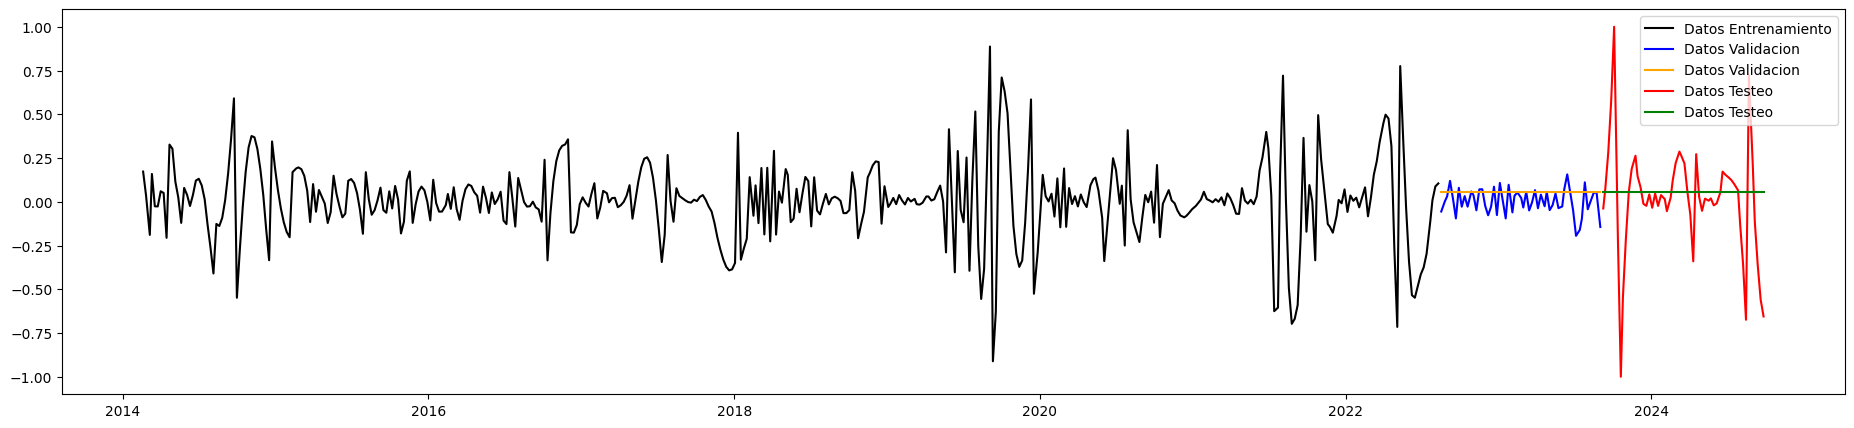

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.PROMEDIO))
print(score)

0.09070852


In [ ]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

#Modelamos Modo 2

In [ ]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053


In [ ]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values
datos_validacion_m2_values = datos_validacion_m2.values
datos_testeo_m2_values = datos_testeo_m2.values

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


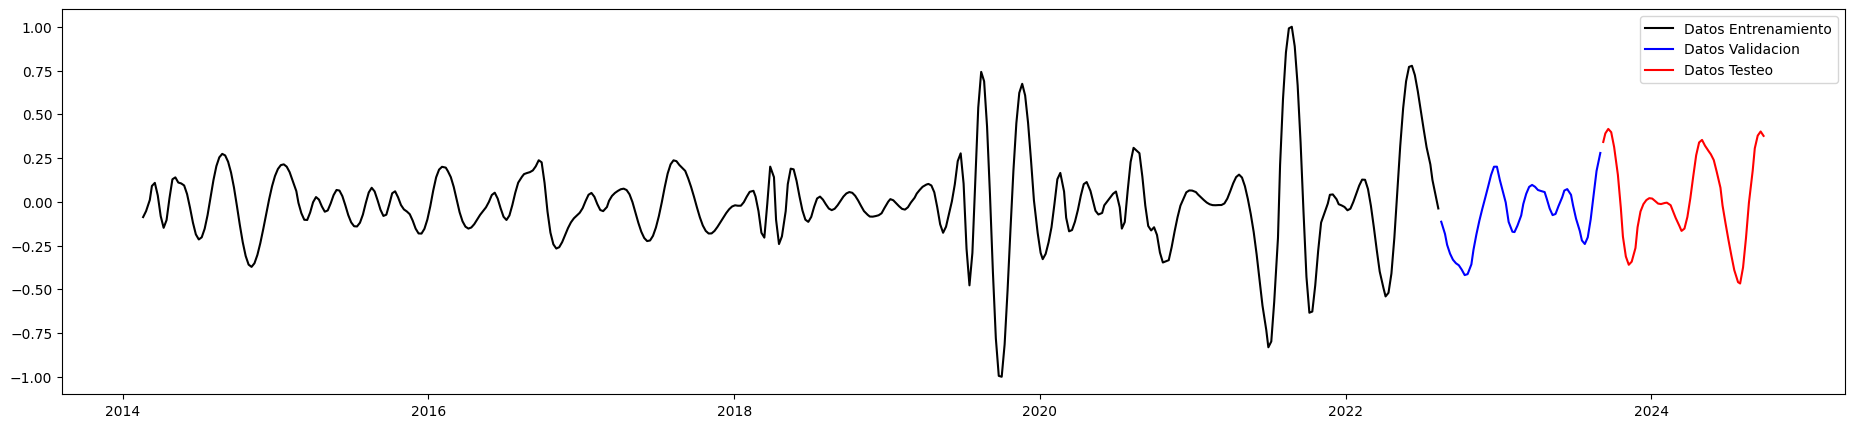

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
def modeloRR_m2():
  modelo = Sequential()
  modelo.add(LSTM(units=45, input_shape=(1,PASOS), activation='tanh',return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(0.01), loss='mse')
  return modelo

In [ ]:
modelo = modeloRR_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0241
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 16/40
63/63 ━━━━━━━━━━━━

In [ ]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


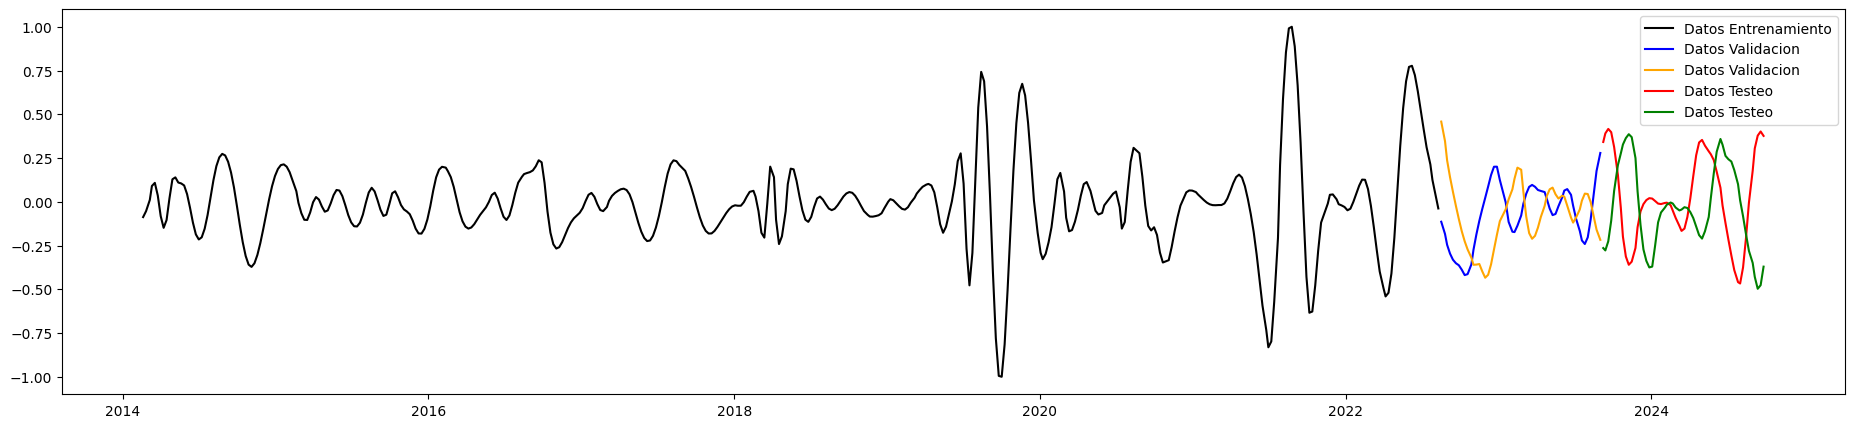

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2.reshape(54),datos_validacion_m2.PROMEDIO))
print(score)

0.27942115


In [ ]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos Residuo

In [ ]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638,-1.000000
2014-02-26,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638
2014-03-07,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115
2014-03-12,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275
2014-03-19,-0.906428,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960


In [ ]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


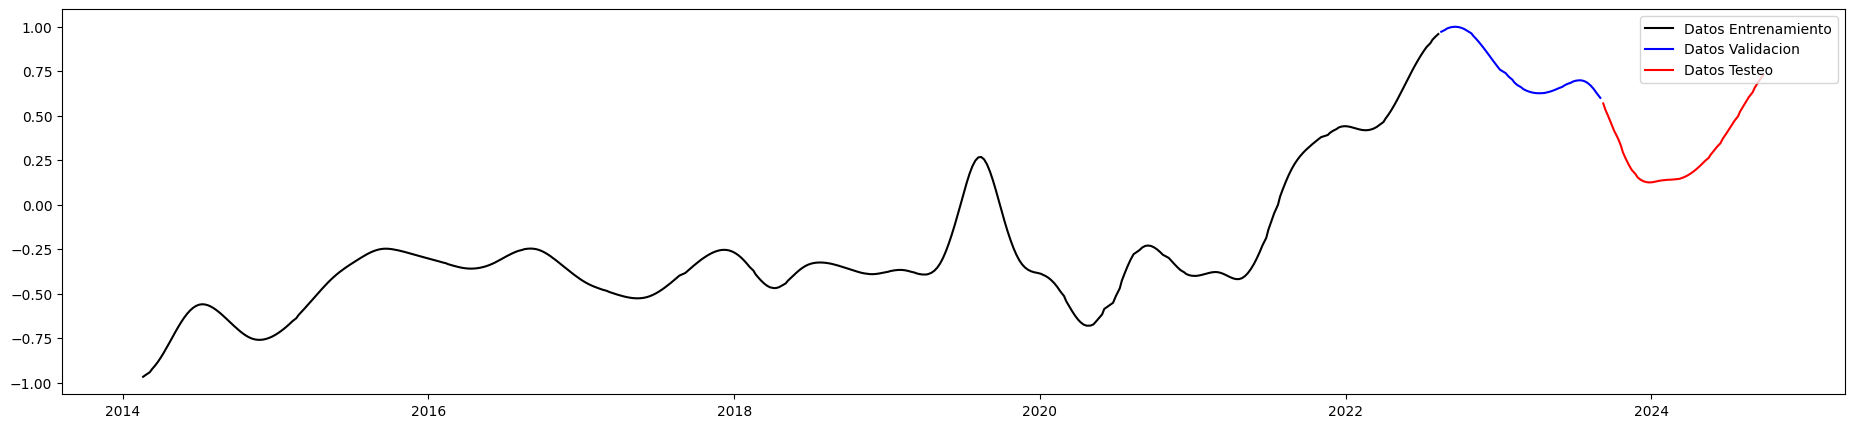

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#Este modelo me esta dando un RECM de 0.009257653
def modeloRR_residuo():
  modelo = Sequential()
  modelo.add(LSTM(units=PASOS, input_shape=(1,PASOS), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=50, activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=50, activation='tanh'))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [ ]:
modelo = modeloRR_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1506
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0498
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7848e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0580e-04
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3127e-04
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6099e-04
Epoch 16/40


In [ ]:

prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


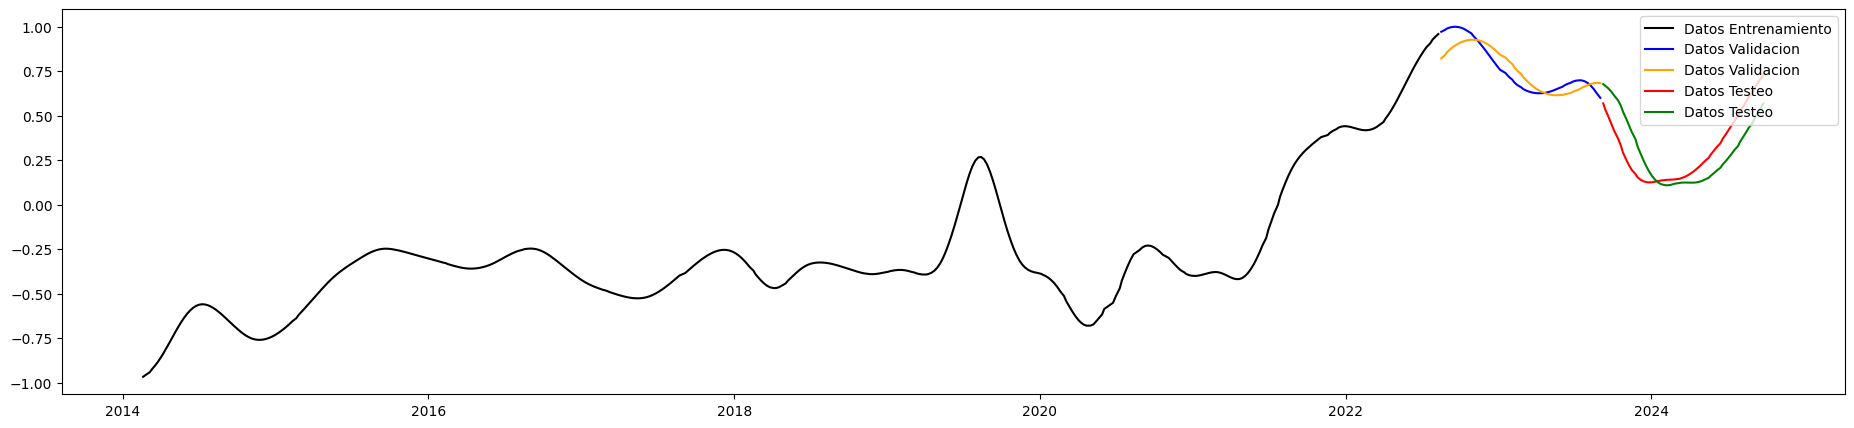

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_residuo,datos_validacion_residuo.PROMEDIO))
print(score)

0.06687465


In [ ]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
datos_emd
validacion = prediccion_validacion_m1 + prediccion_validacion_m2 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m1 + prediccion_testeo_m2 + prediccion_testeo_residuo

In [ ]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [ ]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 66.68588398599395 
el error absoluto medio del modelo es: 50.821497034143086 
Error porcentual absoluto medio del modelo es: 0.01948390693453377


In [ ]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.PROMEDIO))
eam = mean_absolute_error( testeo,datos_testeo.PROMEDIO)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.PROMEDIO)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 210.94169674879518 
el error absoluto medio del modelo es: 149.3727416992188 
Error porcentual absoluto medio del modelo es: 0.0665866867748877


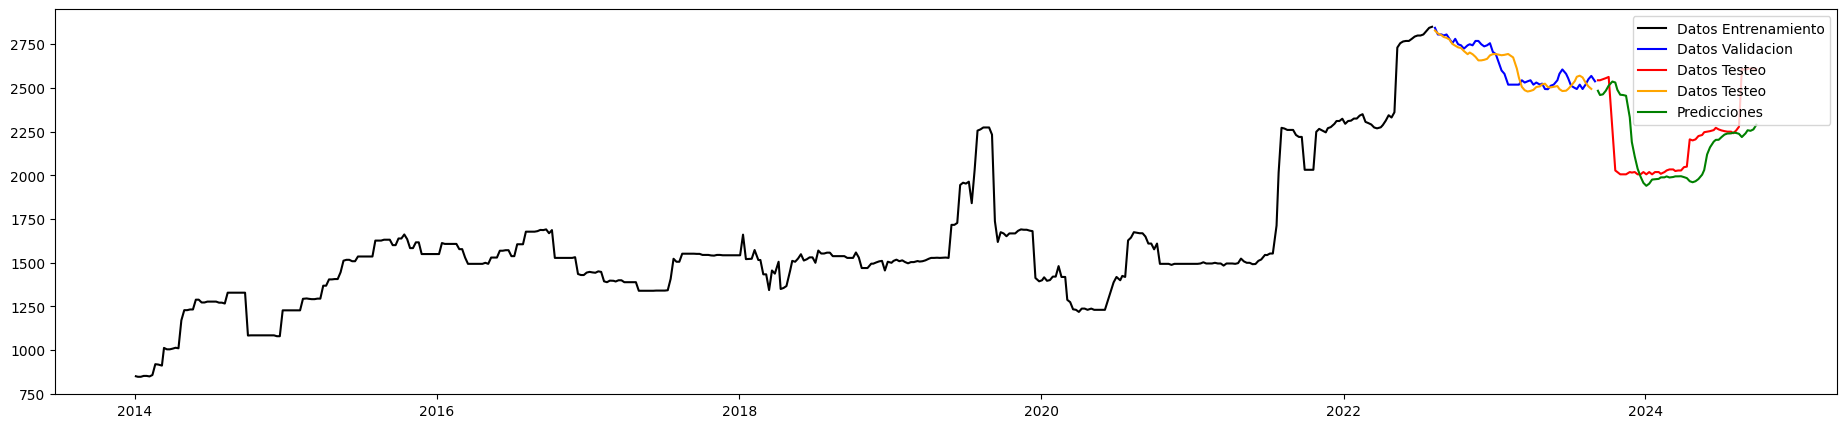

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index[:-1],validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

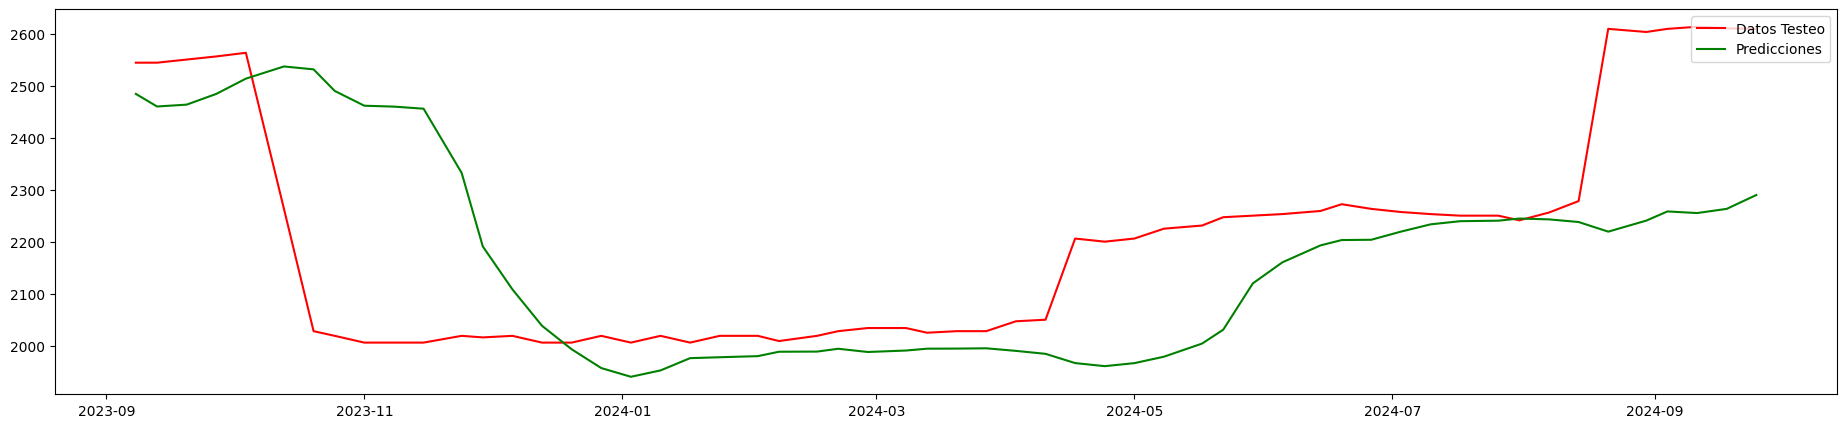

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['PROMEDIO'])
testeo = pd.DataFrame(testeo,index=datos_testeo.index,columns=['PROMEDIO'])

In [ ]:
#validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/validacion_red_recurrente.csv",index=True)
#testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD//testeo_red_recurrente.csv",index=True)
